# Deep Learning: Laparoscopic segmentation.
[Dataset](https://www.kaggle.com/datasets/newslab/cholecseg8k?resource=download)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2
import tensorflow as tf
import keras.backend as K
from sklearn.model_selection import train_test_split
from glob import glob
import segmentation_models as sm


Segmentation Models: using `keras` framework.


In [2]:
tf.keras.backend.clear_session()
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
print('GPU avalible: ' + str(len(tf.config.get_visible_devices('GPU')) > 0))

GPU avalible: False


In [3]:
SEED = 17
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

## Data preparation.

In [4]:
imgs = glob(f'../*/*/*/frame_*_endo.png')
masks = glob(f'../*/*/*/frame_*_endo_watershed_mask.png')
_, imgs, _, masks = train_test_split(imgs, masks, test_size=0.2, random_state=43)
assert len(imgs) == len(masks)

print(f'Number of samples: {str(len(masks))}')

Number of samples: 1616


In [5]:
HEIGHT, WIDTH = 64, 64
N_CLASSES = 13
N = len(masks)

CLASS_WEIGHTS = [2.45780159e-01, 2.24610010e-01, 2.24005501e-01, 1.87119512e-02,
 1.46965911e-01, 2.54698498e-02, 2.35562466e-02, 4.28713053e-03,
 3.93593665e-04, 1.38500705e-02, 6.78984614e-02, 1.01436955e-04,
 4.36967906e-03]

In [6]:
# https://gist.github.com/IdeaKing/11cf5e146d23c5bb219ba3508cca89ec
def resize_with_pad(image: np.array, 
                    new_shape, 
                    padding_color = (0, 0, 0)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [7]:
X, y = [], []

for img, mask in zip(imgs, masks):
    img = cv2.imread(img)
    img = img[10:-10, 120:-120,:]
    img = resize_with_pad(img, (HEIGHT, WIDTH))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    X.append(img)

    mask = cv2.imread(mask)
    mask = mask[10:-10, 120:-120,:]
    mask = resize_with_pad(mask, (HEIGHT, WIDTH), (50, 50, 50))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = np.expand_dims(mask, axis=-1)

    y.append(mask)

X = np.array(X)
y = np.array(y)

assert X.shape[0:-1] == y.shape[0:-1]

X.shape, y.shape

((1616, 64, 64, 3), (1616, 64, 64, 1))

In [8]:
labels = [[11],[21],[13],[12],[31],[23],[24],[25],[32],[22],[33],[5]]
labels_encoding = {
    0: 'BG',
    1: 'Abdominal Wall',
    2: 'Liver',
    3: 'Gastrointestinal Tract',
    4: 'Fat',
    5: 'Grasper',
    6: 'Connective Tissue',
    7: 'Blood',
    8: 'Cystic Duct',
    9: 'L-hook Electrocautery',
    10: 'Gallbladder',
    11: 'Hepatic Vein',
    12: 'Liver Ligament',
}
y_encoded = np.zeros((N, HEIGHT, WIDTH, 1), dtype=np.uint8)

for i, label in enumerate(labels):
    y_encoded[np.all(label == y, axis=-1)] = i + 1
 
y = tf.keras.utils.to_categorical(y_encoded, num_classes=13)

## U-Net

In [9]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = tf.keras.layers.MaxPool2D(2)(f)
   p = tf.keras.layers.BatchNormalization()(p)
   p = tf.keras.layers.Dropout(0.2)(p)

   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = tf.keras.layers.concatenate([x, conv_features])
   # dropout
   x = tf.keras.layers.BatchNormalization()(x)
   x = tf.keras.layers.Dropout(0.2)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

def build_unet_model(n_filters=64, n_classes=2):
   # inputs
   inputs = tf.keras.layers.Input(shape=(HEIGHT,WIDTH,3))

   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, n_filters)
   # 2 - downsample
   f2, p2 = downsample_block(p1, n_filters*2)
   # 3 - downsample
   f3, p3 = downsample_block(p2, n_filters*4)
   # 4 - downsample
   f4, p4 = downsample_block(p3, n_filters*8)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, n_filters*16)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, n_filters*8)
   # 7 - upsample
   u7 = upsample_block(u6, f3, n_filters*4)
   # 8 - upsample
   u8 = upsample_block(u7, f2, n_filters*2)
   # 9 - upsample
   u9 = upsample_block(u8, f1, n_filters)

   # outputs
   
   activation = 'sigmoid' if n_classes == 2 else 'softmax'
   outputs = tf.keras.layers.Conv2D(n_classes, 1, padding="same", activation=activation)(u9)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

In [10]:
def dice_coeficient(y_true, y_pred):
    T = tf.keras.backend.flatten(y_true)
    P = tf.keras.backend.flatten(y_pred)

    intersection = tf.keras.backend.sum(T * P)
    dice = (2 * intersection) / (tf.keras.backend.sum(T + P))
    return dice

def dice_loss(y_true, y_pred):
    return 1 - dice_coeficient(y_true, y_pred)

def tversky(y_true, y_pred, smooth=1, alpha=0.8):
    T = tf.keras.backend.flatten(y_true)
    P = tf.keras.backend.flatten(y_pred)
    TP = tf.keras.backend.sum(T * P)
    FN = tf.keras.backend.sum(T * (1 - P))
    FP = tf.keras.backend.sum((1 - T) * P)
    return (TP + smooth) / (TP + alpha * FN + (1 - alpha) * FP + smooth)


def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return tf.keras.backend.pow((1 - tv), gamma)

def generalized_dice_coeff(y_true, y_pred, smooth=1e-9):
    Ncl = y_pred.shape[-1]
    w = np.zeros((Ncl,))
    w = K.sum(y_true, (0,1,2))
    w = 1 / (w ** 2 + smooth)

    y_pred = tf.nn.softmax(y_pred)

    # Compute gen dice coef:
    numerator = y_true * y_pred
    numerator = w * K.sum(numerator, (0,1,2))
    numerator = K.sum(numerator)

    denominator = y_true + y_pred
    denominator = w * K.sum(denominator, (0,1,2))
    denominator = K.sum(denominator)

    return 2. * (numerator + smooth) / (denominator + smooth)


def generalized_dice_loss(y_true, y_pred):
    return 1. - generalized_dice_coeff(y_true, y_pred)

In [11]:


unet_model = build_unet_model(n_filters=32, n_classes=13)
unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), 
    loss=sm.losses.DiceLoss(class_weights=CLASS_WEIGHTS),
    metrics=[tf.metrics.MeanIoU(num_classes=13), dice_coeficient]
)
unet_model.load_weights('../models/u-net-BN_diceLoss.hdf5')

print('\n\t EVALUATION\n')
_, finalIoU, finalDice = unet_model.evaluate(
    X, 
    y,
    batch_size=32
)


	 EVALUATION

51/51 [==============================] - 37s 676ms/step - loss: 0.9248 - mean_io_u: 0.9745 - dice_coeficient: 0.9810


In [12]:
pred = unet_model.predict(X)
pred = np.array(pred)

51/51 [==============================] - 23s 437ms/step


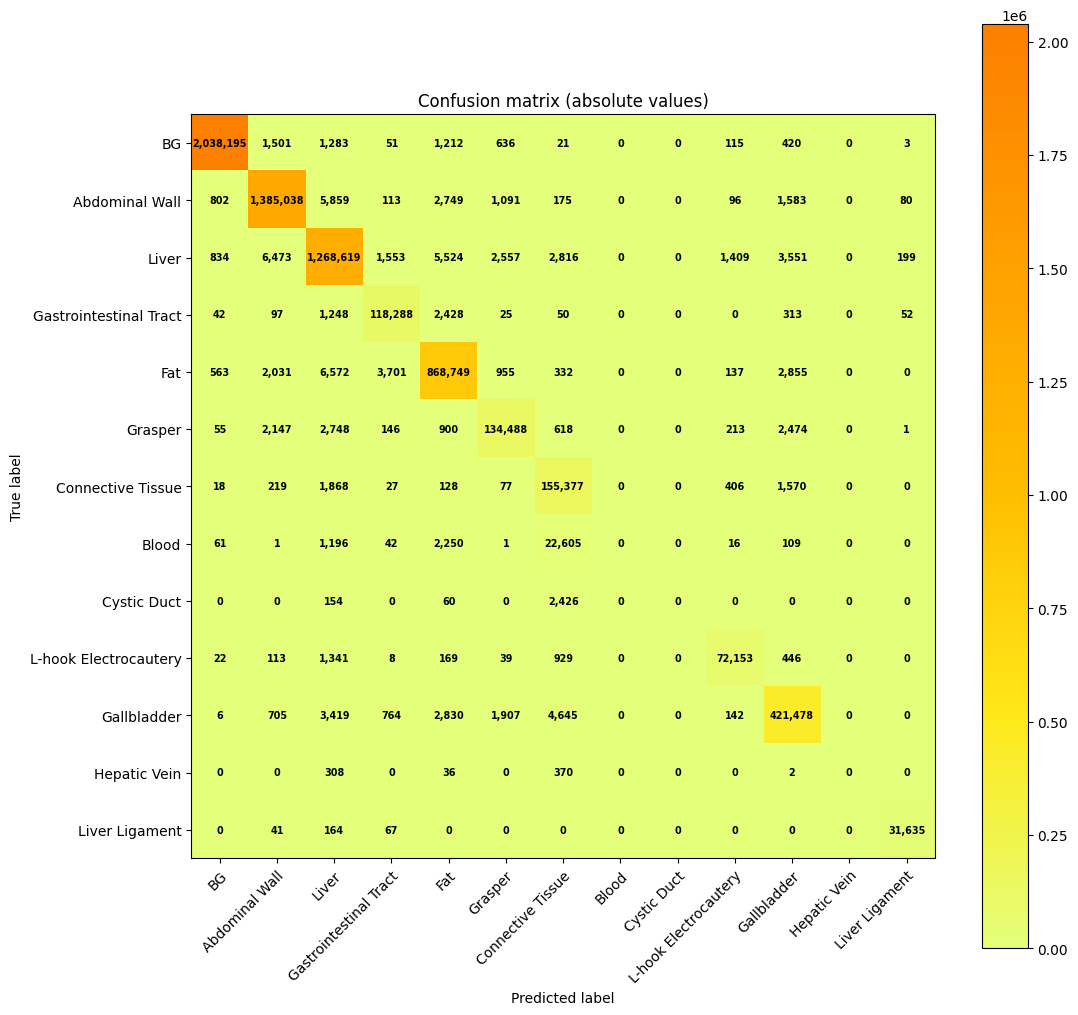

In [13]:
from sklearn.metrics import confusion_matrix

y_true = tf.argmax(y, axis=-1).numpy().reshape((-1, 1))
y_pred = tf.argmax(pred, axis=-1).numpy().reshape((-1, 1))
confusion_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12,12))
plt.xticks(np.arange(0,13, 1), labels=labels_encoding.values(), rotation=45, ha="right", rotation_mode="anchor")
plt.yticks(np.arange(0,13, 1), labels=labels_encoding.values())
plt.title('Confusion matrix (absolute values)')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.imshow(confusion_mat, cmap='Wistia')
plt.colorbar()
for i in range(len(confusion_mat)):
    for j in range(len(confusion_mat[0])):
        plt.text(j, i, f"{confusion_mat[i, j]:,}",
                       ha="center", va="center", color="black", fontsize='x-small', fontweight="bold")
plt.show()

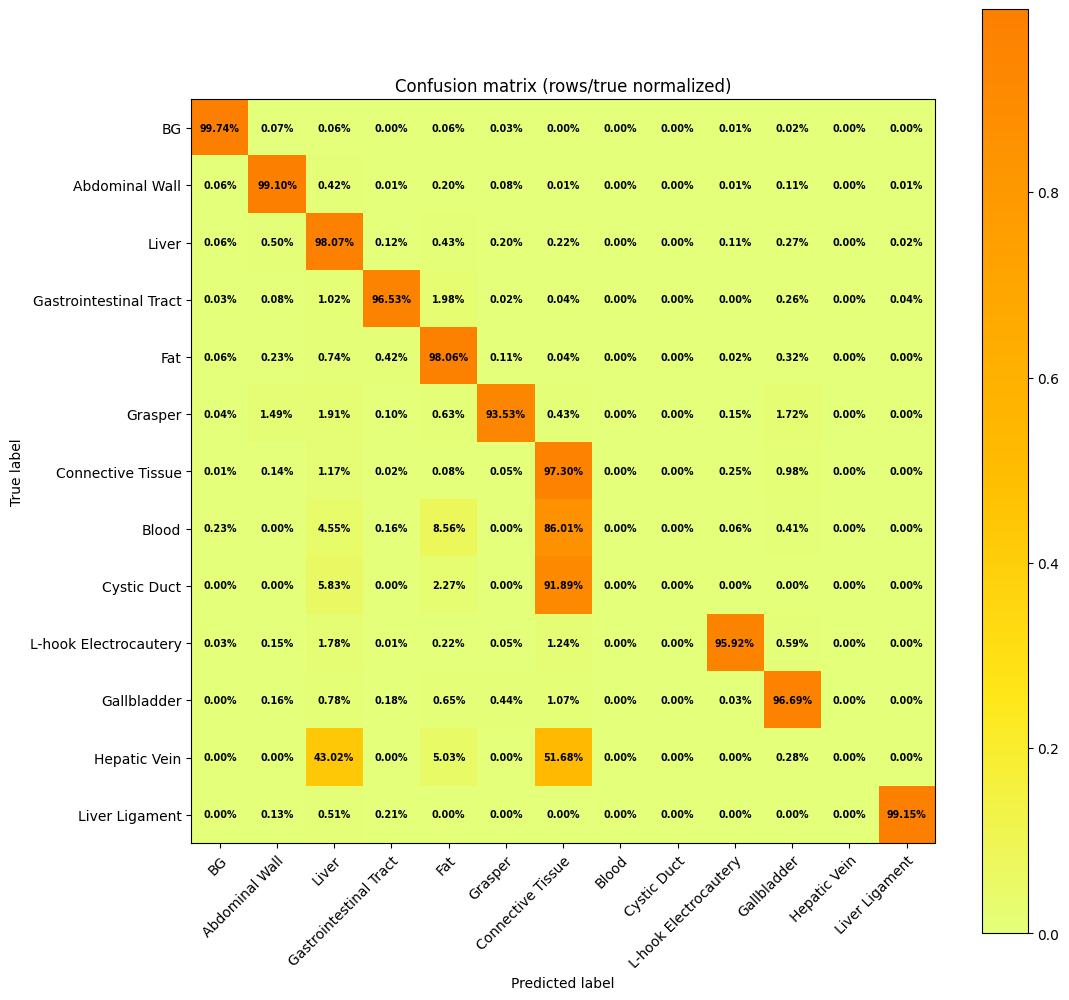

In [14]:
confusion_mat = confusion_matrix(y_true, y_pred, normalize='true')

plt.figure(figsize=(12,12))
plt.xticks(np.arange(0,13, 1), labels=labels_encoding.values(), rotation=45, ha="right", rotation_mode="anchor")
plt.yticks(np.arange(0,13, 1), labels=labels_encoding.values())
plt.title('Confusion matrix (rows/true normalized)')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.imshow(confusion_mat, cmap='Wistia')
plt.colorbar()
for i in range(len(confusion_mat)):
    for j in range(len(confusion_mat[0])):
        plt.text(j, i, f"{confusion_mat[i, j]*100:.2f}%",
                       ha="center", va="center", color="black", fontsize='x-small', fontweight="bold")
plt.show()

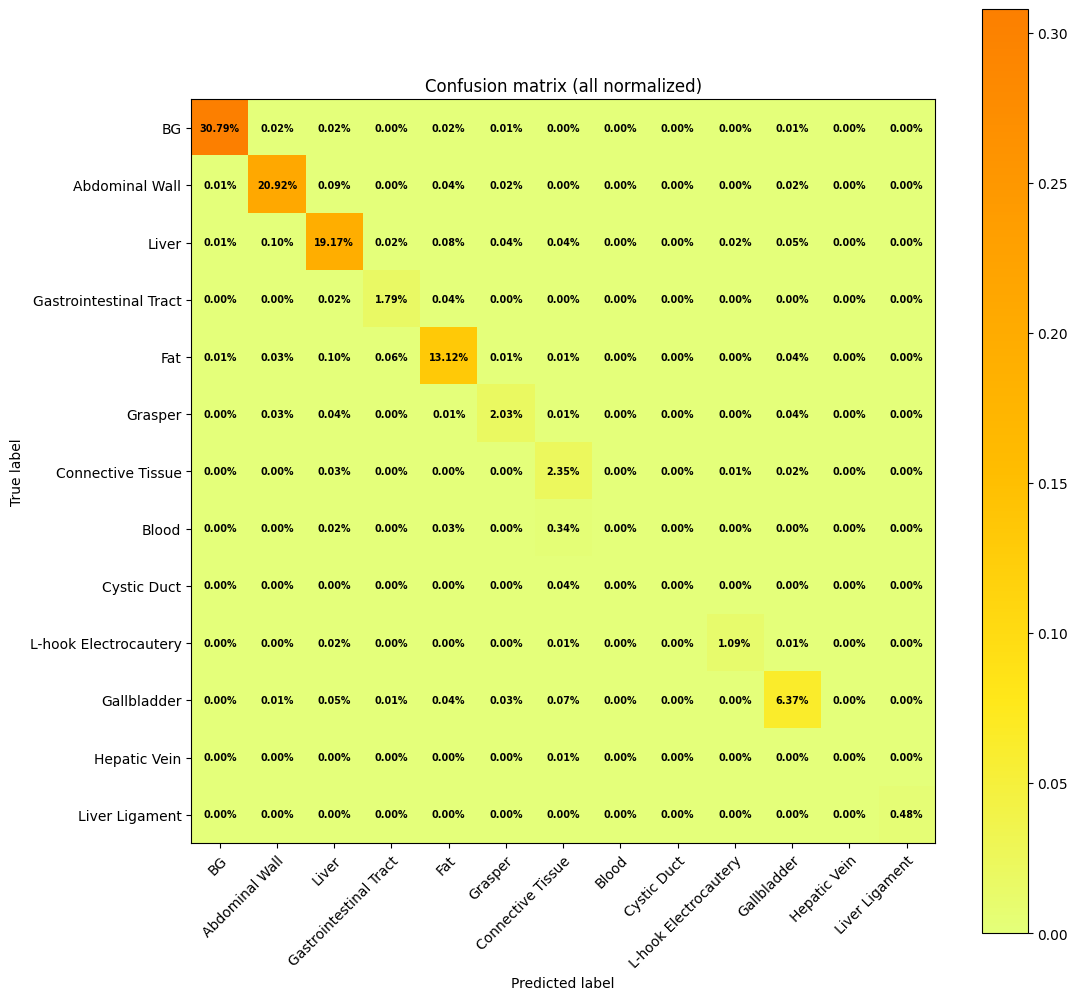

In [15]:
confusion_mat = confusion_matrix(y_true, y_pred, normalize='all')

plt.figure(figsize=(12,12))
plt.xticks(np.arange(0,13, 1), labels=labels_encoding.values(), rotation=45, ha="right", rotation_mode="anchor")
plt.yticks(np.arange(0,13, 1), labels=labels_encoding.values())
plt.title('Confusion matrix (all normalized)')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.imshow(confusion_mat, cmap='Wistia')
plt.colorbar()
for i in range(len(confusion_mat)):
    for j in range(len(confusion_mat[0])):
        plt.text(j, i, f"{confusion_mat[i, j]*100:.2f}%",
                       ha="center", va="center", color="black", fontsize='x-small', fontweight="bold")
plt.show()

In [16]:
class_losses = {
    'Dice Coeficient' : [],
    'IoU' : [],
}

for i in range(N_CLASSES):
    class_losses['Dice Coeficient'].append(f'{1-sm.losses.DiceLoss(class_indexes=i)(y, pred).numpy():.5f}')
    class_losses['IoU'].append(f'{sm.metrics.IOUScore(class_indexes=i)(y, pred).numpy():.5f}')
    
indexes = list(labels_encoding.values())

indexes.append('Final')
class_losses['Dice Coeficient'].append(f'{finalDice:.5f}')
class_losses['IoU'].append(f'{finalIoU:.5f}')

pd.DataFrame(class_losses, index=indexes)

,Dice Coeficient,IoU
BG,0.99813,0.99626
Abdominal Wall,0.99071,0.98158
Liver,0.98020,0.96117
Gastrointestinal Tract,0.95640,0.91644
Fat,0.97996,0.96070
Grasper,0.94155,0.88956
Connective Tissue,0.88764,0.79798
Blood,0.00000,0.00000
Cystic Duct,0.00000,0.00000
L-hook Electrocautery,0.96255,0.92781


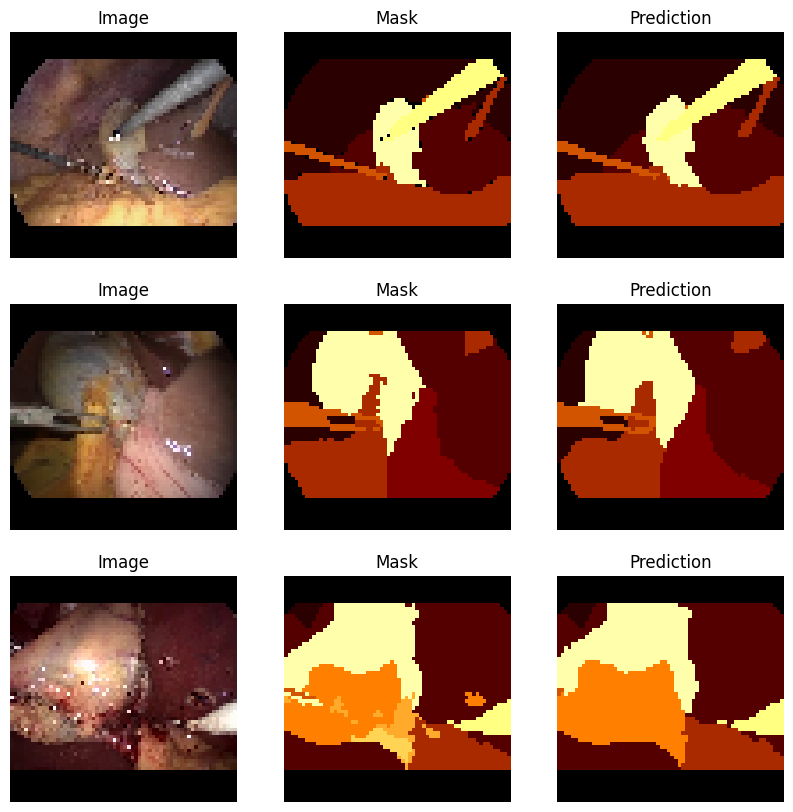

In [17]:
idxs = [1003, 13, 205]
plt.figure(figsize=(10,10))
for i in range(3):    
    idx = idxs[i]

    plt.subplot(331 + 3*i)
    plt.imshow(X[idx])
    plt.title('Image')
    plt.axis("off")

    plt.subplot(332 + 3*i)
    plt.imshow(tf.argmax(y[idx], axis=-1), cmap='afmhot', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Mask')
    plt.axis("off")

    plt.subplot(333 + 3*i)
    plt.imshow(tf.argmax(pred[idx], axis=-1), cmap='afmhot',  norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Prediction')
    plt.axis("off")

plt.show()

--
**TFG - Adrián Contreras Castillo**
--